# 深度学习100例-循环神经网络（RNN）实现股票预测 | 第9天

我们的代码流程图如下所示：  
![](https://img-blog.csdnimg.cn/d1e774d8e5584a5a9858d050cf7aa333.png)

## RNN是什么

传统神经网络的结构比较简单：输入层 – 隐藏层 – 输出层

![在这里插入图片描述](https://img-blog.csdnimg.cn/20210609190035917.png#pic_center)

RNN 跟传统神经网络最大的区别在于每次都会将前一次的输出结果，带到下一次的隐藏层中，一起训练。如下图所示：  
![在这里插入图片描述](https://img-blog.csdnimg.cn/20210609190120545.gif#pic_center)

这里用一个具体的案例来看看 RNN 是如何工作的：

用户说了一句“what time is it？”，我们的神经网络会先将这句话分为五个基本单元（四个单词+一个问号）

![在这里插入图片描述](https://img-blog.csdnimg.cn/20210609190139960.gif#pic_center)

然后，按照顺序将五个基本单元输入RNN网络，先将 “what”作为RNN的输入，得到输出`01`

![在这里插入图片描述](https://img-blog.csdnimg.cn/20210609190153448.gif#pic_center)

随后，按照顺序将“time”输入到RNN网络，得到输出`02`。

这个过程我们可以看到，输入 “time” 的时候，前面“what” 的输出也会对`02`的输出产生了影响（隐藏层中有一半是黑色的）。

![](https://img-blog.csdnimg.cn/20210609190204411.gif#pic_center)

以此类推，我们可以看到，前面所有的输入产生的结果都对后续的输出产生了影响（可以看到圆形中包含了前面所有的颜色）

![](https://img-blog.csdnimg.cn/20210609190216554.gif#pic_center)

当神经网络判断意图的时候，只需要最后一层的输出`05`，如下图所示：

![](https://img-blog.csdnimg.cn/2021060919023244.gif#pic_center)

## 1.准备工作

### 1.1 加载数据

In [8]:
import os,math
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from sklearn.preprocessing   import MinMaxScaler
from sklearn                 import metrics
import numpy             as np
import pandas            as pd
import tensorflow        as tf
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

《深度学习100例》第9天的数据链接如下

https://pan.baidu.com/s/1ojOSS8I7F4E_uoPBq0HTUg（提取码：94ho）

In [9]:
data = pd.read_csv('F:\DeepLearning\day-9\SH600519.csv')  # 读取股票文件

data

,Unnamed: 0,date,open,close,high,low,volume,code
0,74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
1,75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
2,76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
3,77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
4,78,2010-04-30,83.871,82.340,83.871,81.523,85566.70,600519
...,...,...,...,...,...,...,...,...
2421,2495,2020-04-20,1221.000,1227.300,1231.500,1216.800,24239.00,600519
2422,2496,2020-04-21,1221.020,1200.000,1223.990,1193.000,29224.00,600519
2423,2497,2020-04-22,1206.000,1244.500,1249.500,1202.220,44035.00,600519
2424,2498,2020-04-23,1250.000,1252.260,1265.680,1247.770,26899.00,600519


In [10]:
"""
前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
后300天的开盘价作为测试集
"""
training_set = data.iloc[0:2426 - 300, 2:3].values  
test_set = data.iloc[2426 - 300:, 2:3].values  

In [11]:
## 2.数据预处理

### 2.1 归一化

In [12]:
sc           = MinMaxScaler(feature_range=(0, 1))
training_set = sc.fit_transform(training_set)
test_set     = sc.transform(test_set) 

In [13]:
### 2.2 设置测试集训练集

In [14]:
x_train = []
y_train = []

x_test = []
y_test = []

"""
使用前60天的开盘价作为输入特征x_train
    第61天的开盘价作为输入标签y_train
    
for循环共构建2426-300-60=2066组训练数据。
       共构建300-60=260组测试数据
"""
for i in range(60, len(training_set)):
    x_train.append(training_set[i - 60:i, 0])
    y_train.append(training_set[i, 0])
    
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
    
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

In [15]:
"""
将训练数据调整为数组（array）

调整后的形状：
x_train:(2066, 60, 1)
y_train:(2066,)
x_test :(240, 60, 1)
y_test :(240,)
"""
x_train, y_train = np.array(x_train), np.array(y_train) # x_train形状为：(2066, 60, 1)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

"""
输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
"""
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
x_test  = np.reshape(x_test,  (x_test.shape[0], 60, 1))

In [16]:
## 3. 构建模型

In [17]:
model = tf.keras.Sequential([
    SimpleRNN(100, return_sequences=True), #布尔值。是返回输出序列中的最后一个输出，还是全部序列。
    Dropout(0.1),                         #防止过拟合
    SimpleRNN(100),
    Dropout(0.1),
    Dense(1)
])

In [18]:
## 4. 激活模型

In [19]:
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差

In [20]:
## 5. 训练模型

In [21]:
history = model.fit(x_train, y_train, 
                    batch_size=64, 
                    epochs=20, 
                    validation_data=(x_test, y_test), 
                    validation_freq=1)                  #测试的epoch间隔数

model.summary()

Epoch 1/20
33/33 [==============================] - 3s 40ms/step - loss: 0.1262 - val_loss: 0.0670
Epoch 2/20
33/33 [==============================] - 1s 26ms/step - loss: 0.0172 - val_loss: 0.0786
Epoch 3/20
33/33 [==============================] - 1s 28ms/step - loss: 0.0126 - val_loss: 0.0037
Epoch 4/20
33/33 [==============================] - 1s 27ms/step - loss: 0.0089 - val_loss: 0.0160
Epoch 5/20
33/33 [==============================] - 1s 27ms/step - loss: 0.0064 - val_loss: 0.0352
Epoch 6/20
33/33 [==============================] - 1s 27ms/step - loss: 0.0052 - val_loss: 0.0207
Epoch 7/20
33/33 [==============================] - 1s 30ms/step - loss: 0.0048 - val_loss: 0.0307
Epoch 8/20
33/33 [==============================] - 1s 30ms/step - loss: 0.0046 - val_loss: 0.0255
Epoch 9/20
33/33 [==============================] - 1s 28ms/step - loss: 0.0037 - val_loss: 0.0246
Epoch 10/20
33/33 [==============================] - 1s 27ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 11/

In [22]:
## 6. 结果结果可视化

### 6.1 绘制loss图

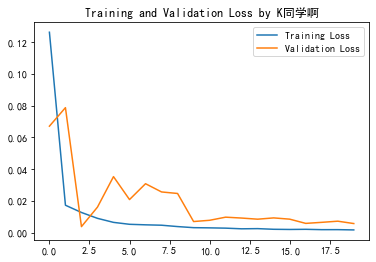

In [23]:
plt.plot(history.history['loss']    , label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss by K同学啊')
plt.legend()
plt.show()

In [24]:
### 6.2 预测

8/8 [==============================] - 0s 7ms/step


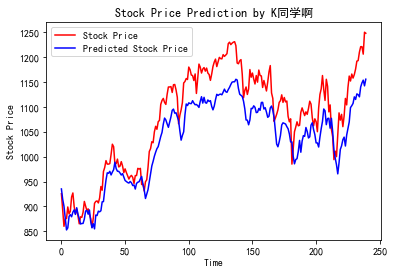

In [25]:
predicted_stock_price = model.predict(x_test)                       # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])              # 对真实数据还原---从（0，1）反归一化到原始范围

# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction by K同学啊')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [26]:
### 6.3 评估

In [27]:
"""
MSE  ：均方误差    ----->  预测值减真实值求平方后求均值
RMSE ：均方根误差  ----->  对均方误差开方
MAE  ：平均绝对误差----->  预测值减真实值求绝对值后求均值
R2   ：决定系数，可以简单理解为反映模型拟合优度的重要的统计量

详细介绍可以参考文章：https://blog.csdn.net/qq_38251616/article/details/107997435
"""
MSE   = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE  = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE   = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2    = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

均方误差: 2832.57154
均方根误差: 53.22191
平均绝对误差: 46.33862
R2: 0.59097
